<a href="https://colab.research.google.com/github/Tahahaha7/Capstone_Project/blob/master/Capstone_Modeling_M3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!apt install libspatialindex-dev
!pip install rtree
!pip install momepy
!pip install osmapi
!pip install pygeos

In [3]:
%%capture
!pip install -Iv osmnx==0.16.0

In [4]:
%%capture
!pip install geopandas
!pip install humanfriendly
!pip install mplleaflet

In [5]:
%%capture
!pip install pandas==1.1.3

In [ ]:
# Importing packages

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import operator
import rtree
import osmnx as ox
import geopandas as gpd
import momepy

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
ox.config(use_cache=True, log_console=True)
weight = 'length'

ox.__version__, pd.__version__

# $\text{Compiling all the data}$

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
#drive.mount("/content/gdrive", force_remount=True)

In [4]:
%cd /content/gdrive/My Drive/Capstone

/content/gdrive/My Drive/Capstone


## $\text{Road Network}$

In [ ]:
# Exrtact the entire road network of the city

%%time
road_network = ox.graph_from_place('London, UK', network_type='drive')

In [ ]:
fig, ax = ox.plot_graph(road_network, node_size=1, edge_color='w', edge_linewidth=0.2, figsize=(25, 15))

In [5]:
#final_osm_nodes = gpd.read_file('final_osm_nodes.gpkg', driver='GPKG')
from shapely import wkt

#final_osm_nodes = gpd.read_file('final_osm_nodes.gpkg', driver='GPKG')
final_osm_nodes = pd.read_csv('final_osm_nodes.csv')
final_osm_nodes['geometry'] = final_osm_nodes['geometry'].apply(wkt.loads)

In [6]:
# Add the nodes for hospitals
from ast import literal_eval
from shapely.ops import nearest_points
from shapely.geometry import Point, MultiPoint

london_hospitals = pd.read_csv('london_hospitals.csv')
london_hospitals.location  = [literal_eval(london_hospitals.location[i]) for i in range(len(london_hospitals))]
london_hospitals.location = [Point(x,y) for [x,y] in london_hospitals.location]

In [7]:
near = [nearest_points(hospital, MultiPoint(final_osm_nodes.geometry))[1] for hospital in london_hospitals.location]
final_osm_nodes['hospital'] = [True if node in near else False for node in final_osm_nodes.geometry]

hospital_name = [np.nan]*len(final_osm_nodes); count = 0
for idx, i in enumerate(final_osm_nodes.hospital):
    if i: 
        hospital_name[idx] = london_hospitals['name'][count]
        count+=1

final_osm_nodes['hospital_name'] = hospital_name
final_osm_nodes['hospital_name'].value_counts()

Royal London Hospital for Integrated Medicine    1
St Thomas' Hospital                              1
The Royal London Hospital                        1
University College Hospital                      1
The Princess Grace Hospital                      1
King Edward VII's Hospital                       1
London Bridge Hospital                           1
Name: hospital_name, dtype: int64

In [8]:
#uber_osm = gpd.read_file("uber_osm.gpkg", driver="GPKG")
uber_osm = pd.read_csv('uber_osm.csv')

In [9]:
uber_osm['speed_mean_mps'] = uber_osm['speed_mean_mph'].fillna(uber_osm['maxspeed'].astype(int)).values * 0.44704 # from mph to m/s
uber_osm['mean_travel_time'] = uber_osm.length.values / uber_osm.speed_mean_mps.values

In [ ]:
uber_osm.isna().sum()

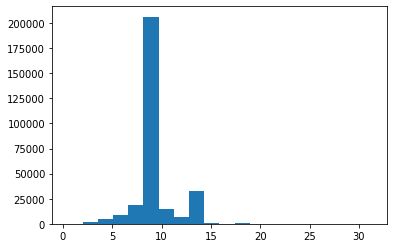

In [ ]:
plt.hist(uber_osm['speed_mean_mps'], bins='auto');

In [10]:
Graph = nx.from_pandas_edgelist(uber_osm,
                                source='osmid_source', 
                                target='osmid_target', 
                                create_using=nx.MultiDiGraph(), 
                                edge_attr=['name', 'length', 'maxspeed', 'speed_mean_mph',
                                           'pct_from_freeflow', 'speed_freeflow_mph',
                                           'mean_travel_time', 'speed_mean_mps', 
                                           'geometry'])

print(nx.info(Graph))

Name: 
Type: MultiDiGraph
Number of nodes: 126768
Number of edges: 297638
Average in degree:   2.3479
Average out degree:   2.3479


In [ ]:
nx.is_weakly_connected(Graph)

True

In [11]:
dict_osm = {x: {'position': (a, b), 'imd': c, 
                'station': (d, dd), 'hospital': (m, mm),
                'population':e, 'children':f, 'elderly':g,
                'men':h, 'women':i, 'women_15_49':j, 'youth':k}
            for x, a, b, c, d, dd, m, mm, e, f, g, h, i, j, k in zip(final_osm_nodes.osmid, final_osm_nodes.x, 
                                                                     final_osm_nodes.y, final_osm_nodes.imd, 
                                                                     final_osm_nodes.station, final_osm_nodes.station_name,
                                                                     final_osm_nodes.hospital, final_osm_nodes.hospital_name,
                                                          final_osm_nodes.population, 
                                                          final_osm_nodes.children, final_osm_nodes.elderly, 
                                                          final_osm_nodes.men, final_osm_nodes.women, 
                                                          final_osm_nodes.women_15_49, final_osm_nodes.youth)}

nx.set_node_attributes(Graph, dict_osm)

In [ ]:
#list(Graph.edges(data=True))[0]
list(Graph.nodes(data=True))[0]

In [ ]:
# Relabeling nodes just to draw

Graph_copy = Graph.copy()
Graph_copy = nx.relabel_nodes(Graph_copy, dict(zip(Graph_copy.nodes, range(len(Graph_copy.nodes)))))

plt.figure(figsize=(25, 15))
nx.draw(Graph_copy, pos = [Graph_copy.nodes[i]['position'] for i in Graph_copy.nodes],
        node_size=10, node_color = 'blue', with_labels=False)
plt.show()

# $\text{Fixed Ambulance Stations}$

In [ ]:
# Faster runs

#list(np.random.choice(list(Graph_copy.nodes), p=normalized_population, size=100))
def find(s, t):
  try: nx.dijkstra_path(Graph_copy, s, t, weight='mean_travel_time')
  except: return 1

find(0, 115598)
#edge_list = list(map(tuple, zip(edge_list, edge_list[1:])))

#trv_cost = 0
#for i in edge_list: trv_cost+=Graph_copy.get_edge_data(i[0], i[1])[0]['mean_travel_time']

1

In [12]:
Graph_copy = Graph.copy() 
#Graph_copy = nx.subgraph(Graph, np.random.choice(Graph.nodes, size=10000))
Graph_copy = nx.relabel_nodes(Graph_copy, dict(zip(Graph_copy.nodes, range(len(Graph_copy.nodes)))))

print(nx.info(Graph_copy))

Name: 
Type: MultiDiGraph
Number of nodes: 126768
Number of edges: 297638
Average in degree:   2.3479
Average out degree:   2.3479


In [ ]:
%timeit path = nx.shortest_path(Graph_copy, 0, 500, weight='mean_travel_time')

10 loops, best of 5: 45.1 ms per loop


In [ ]:
%load_ext Cython

In [ ]:
%%cython

import numpy as np
import pandas as pd
import networkx as nx

class simulation:
        
    def initialize(self, graph, n_requests, n_ambulances): #, v_ambulance):
        
        self.graph = graph # Graph of the city

        #self.v_ambulance = v_ambulance # measured in m/s

        self.station_nodes = [node[0] for node in self.graph.nodes(data=True) if node[1]['station'][0]]
        self.hospital_nodes = [node[0] for node in self.graph.nodes(data=True) if node[1]['hospital'][0]]
        
        self.n_requests = n_requests # The number of requests
        self.n_ambulances = n_ambulances # The number of ambulances

        self.station_visits = [] # Record the station from which ambulance dispatched
        self.hospital_visits = [] # Record the hospital to which ambulance directed back to

        self.requests = [] # Record the nodes that generated ambulance calls
        self.history = [] # Record the nodes that generated ambulance calls
        self.waitlist = [] # Record the nodes waiting for ambulances
        self.service = [] # Record the nodes being serviced
        
    def generate_requests(self):
        '''
        The function generates emergency calls in different regions of the city
        using a random sampler weighted by the normalized criminality rate.
        (i.e., a region with relatively high criminality rate would have more
        frequent ambulance calls)
        '''

        subgraph = nx.subgraph(self.graph, np.random.choice(self.graph.nodes, size=int(self.n_requests/10)))

        # Put all population estimates of nodes into a list
        population = list(nx.get_node_attributes(self.graph,'population').values())
        sub_population = list(nx.get_node_attributes(subgraph,'population').values())
        category_counts = [12441, 60485, 19972, 1610] # from historical data

        # Normalize all population estimates to serve as a probability distribution
        normalized_population = population / np.sum(population) #population / np.linalg.norm(population)
        normalized_sub_population = sub_population / np.sum(sub_population)
        normalized_category_counts = category_counts / np.sum(category_counts)

        self.requests = list(zip(np.random.choice(list(range(1, 5)), p=normalized_category_counts, size=self.n_requests),
                                 np.random.choice(list(subgraph.nodes), p=normalized_sub_population, size=self.n_requests)))

        #self.requests = list(np.random.choice(list(self.graph.nodes), p=normalized_population, size=self.n_requests))
        
    def estimated_travel_time(self, edge_list):
        '''
        The function estimates the average travel time thru the shortest path between 
        the hospital and the region from which the emergency call was generated.
        
        - Methodology:
        For each edge on the shortest path, a sample is taken from a normal distribution with
        mean = average travel time of the edge
        sd = standard deviation of travel time of the edge
        Note: both estimations of mean and sd are extracted from Uber Movement dataset
        
        - Returns: the sum of edge samples.
        '''
        
        cdef float trv_cost = nx.dijkstra_path_length(self.graph, edge_list[0], edge_list[-1], weight='mean_travel_time')
        #trv_cost = nx.dijkstra_path_length(self.graph, edge_list[0], edge_list[-1], weight='mean_travel_time')

        # Return the total travel time thru the shortest path
        return trv_cost
        
    def shortest_path(self, source):
        '''
        The function computes the shortest path between hospital nodes and the node
        from which the emergency call was generated.
        
        Break-down:
        - Edge: Using Dijkstra method, the mean travel time of edges are used as weights 
          to identify the fastest paths rather than the shorted paths to the emergency node.
          The function evaluates all the hospitals to determine the best option.
          
        - Dispatching: based on the radius of the region from which the ambulace is dispatched
          the estimated time of dispatching is calculated based on the ambulace average speed.
          mean = time for the ambulance to travel the radius of the region
          standard deviation = 5 seconds
        
        - Pick_up: Also based on the radius of the region from which the emergency call was generated
          mean = time for the ambulance to travel the radius of the region
          standard deviation = 10 seconds
          Note: sd is higher because the ambulance is less certain about the emergency call source
          the ambulace average speed is in Km\h hence the conversion to seconds
        '''
        # Identify the hospital node that is fastest to dispatch the ambulance from
        try: 
            edge_to = nx.multi_source_dijkstra(self.graph, sources=self.station_nodes, target=source, weight='mean_travel_time')
            edge_from = nx.multi_source_dijkstra(self.graph, sources=self.hospital_nodes, target=source, weight='mean_travel_time')

        except:
            print(source)
            return 1
        
        # Estimate the time for the ambulance to be dispatched
        #dispatching = np.random.normal((self.graph.nodes[edge[1][-1]]['radius']/(self.v_ambulance))*3600, 5)
        
        # Estimate the time it takes for the ambulance to pick up the patient
        #pick_up = np.random.normal((self.graph.nodes[source]['radius']/(self.v_ambulance))*3600, 10)

        # Record the station from which the ambulance was dispateched and hospital that it traveled to
        self.station_visits.append(edge_to[1][0])
        self.hospital_visits.append(edge_from[1][0])

        #print('edge[1][0]', edge[1][0])
        # Estimate the travel time on the shortest path


        #cdef float trip = self.estimated_travel_time(edge[1])

        cdef float trip_to = self.estimated_travel_time(edge_to[1])
        cdef float trip_from = self.estimated_travel_time(edge_from[1])
        
        # Return the sum of the whole trip
        return trip_to + trip_from #dispatching + trip + pick_up
            
    def run(self):
        '''
        The function runs the simulation for the designated number of requests
        by summing up the shortest path timer for each ambulance dispatching.
        '''

        cdef float emergency_response_timer = 0

        # Generate the requests of emergency service
        self.generate_requests()

        cdef int idx, demand
        cdef float response_time


        while len(self.requests) > 0:
            demand = int(abs(np.random.normal(loc=self.n_ambulances, scale=50)))
            if demand == 0: demand +=1

            #print('demand', demand)
            self.waitlist = self.requests[:min(len(self.requests), demand)]
            #print('waitlist', len(self.waitlist))
            
            if len(self.waitlist) > self.n_ambulances:
                #print('case1')
                self.waitlist = self.waitlist[self.n_ambulances:]
                self.service = self.waitlist[:self.n_ambulances]
                if len(self.service) < len(self.waitlist): self.service, self.waitlist = self.waitlist, self.service

                #print('service', len(self.service)), print('waitlist', len(self.waitlist))

                for idx,i in enumerate(self.service):
                    #if (idx*100 / len(self.requests))%10==0: print('Progress {}%'.format(int(idx*100 / len(self.requests))))
                    # Add up the shortest path time for the ambulance
                    #i = q.get()
                    response_time = self.shortest_path(i[1])
                    self.history.append([i[0], i[1], response_time])
                    emergency_response_timer += response_time

                waiting = sorted([time[2] for time in self.history[-len(self.service):]])[:len(self.waitlist)]
                self.waitlist = sorted(self.waitlist)
                #print(waiting, self.waitlist)
                assert(len(waiting) == len(self.waitlist))
                #print(waiting)

                for idx,i in enumerate(self.waitlist):
                    response_time = self.shortest_path(i[1]) + waiting[idx]
                    self.history.append([i[0], i[1], response_time])
                    emergency_response_timer += response_time

            else: 
                #print('case2')
                self.service = self.waitlist
                for idx,i in enumerate(self.service):
                    #if (idx*100 / len(self.requests))%10==0: print('Progress {}%'.format(int(idx*100 / len(self.requests))))

                    # Add up the shortest path time for the ambulance
                    #i = q.get()
                    response_time = self.shortest_path(i[1])
                    self.history.append([i[0], i[1], response_time])
                    emergency_response_timer += response_time

            self.requests = self.requests[min(len(self.requests), demand):]
            print(len(self.requests))
            #if (idx*100 / len(self.requests))%10==0: print('Progress {}%'.format(int(idx*100 / len(self.requests))))


        # Returns the average responce time for all requests
        return round(emergency_response_timer / self.n_requests, 3)
    
    def station_responces(self):
        '''
        The function returns the count of emergency responses for each station
        '''
        record = {x:[self.graph.nodes[x]['station'][1], self.station_visits.count(x)] for x in self.station_visits}

        return pd.DataFrame.from_dict(record, orient='index', columns=['Name', 'Count']).sort_values(by=['Count'], ascending=False)

    def hospital_responces(self):
        '''
        The function returns the count of emergency responses for each station
        '''
        record = {x:[self.graph.nodes[x]['hospital'][1], self.hospital_visits.count(x)] for x in self.hospital_visits}

        return pd.DataFrame.from_dict(record, orient='index', columns=['Name', 'Count']).sort_values(by=['Count'], ascending=False)
    
    def region_requests(self):
        '''
        The function returns the count of emergency calls for each region
        as well as the overall response time and average response time.
        '''

        # Create a data frame based on the randomly generated requests
        df = pd.DataFrame(self.history, columns=['Priority', 'Node', 'Average response time']).sort_values(by=['Node'])
        #df = pd.DataFrame(self.requests, columns=['Node', 'Average response time']).sort_values(by=['Node'])
        # Count the occurance of emergencies in each region
        #rt = list(df.groupby('Node').count()['Average response time'])
        #df = df.groupby('Node').mean(); df['Count'] = rt

        return df

In [ ]:
sim_example = simulation()

In [ ]:
sim_example.initialize(Graph_copy, 5000, 10) # total number of calls in January 138775

In [ ]:
#%timeit sim_example.generate_requests()
one = [int(abs(np.random.normal(10+20, 50)))-10 for i in range(10**5)]
plt.hist(one, bins='auto');
plt.axvline(np.median(one), c='r'); plt.title(str(np.median(one)));

In [ ]:
normalized_category_counts = [12441, 60485, 19972, 1610] / np.sum([12441, 60485, 19972, 1610])

np.unique(np.random.choice(list(range(1, 5)), p=normalized_category_counts, size=92), return_counts=True)
#np.unique(np.random.choice(list(range(1, 5)), p=normalized_category_counts, size=45), return_counts=True)

In [ ]:
#%timeit sim_example.run()
print('\nTotal Average Response time {} seconds'.format(sim_example.run()))

In [29]:
df = pd.read_csv('results4_requests.csv')
#sim_example.region_requests()
df.head()

,Node,Average response time,Count
0,17109,580.956055,13
1,7942,396.958374,10
2,124581,382.758972,9
3,24740,1029.896118,9
4,108716,588.863708,8


In [ ]:
# Get the number of requests generated from each node

#sim_example.region_requests().sort_values(by=['Count'], ascending=False).head()

rt = list(df.groupby('Priority').count()['Average response time'])
df = df.groupby('Priority').mean(); df['Count'] = rt
df.drop(columns=['Node'])

,Average response time,Count
Priority,,
1,1260.385272,642
2,1289.670637,3128
3,1345.567007,1055
4,1423.530670,82


In [33]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

np.percentile(df['Average response time'], 50)

1194.199462890625

In [37]:
max(df['Average response time']) / 60

51.747334798177086

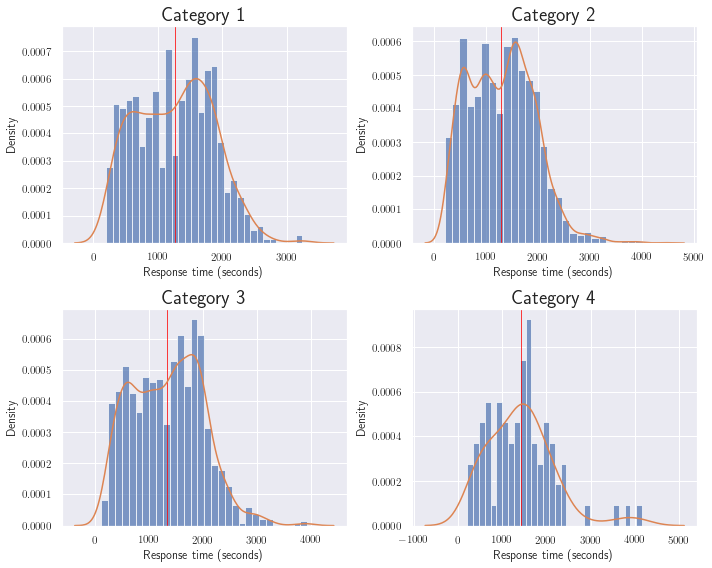

In [ ]:
# hist for each priority level

data = sim_example.region_requests().sort_values(by='Priority')
plt.figure(figsize=(10, 8))

for idx,i in enumerate(data.Priority.unique()):
    plt.subplot(2, 2, idx+1)
    plt.title('Category {}'.format(i), fontsize=20)
    plt.hist(data[data.Priority == i]['Average response time'], bins=30, alpha=.7, density=True)
    plt.axvline(np.mean(data[data.Priority == i]['Average response time']), color='red', Linewidth=.75)
    sns.kdeplot(data[data.Priority == i]['Average response time'])
    plt.xlabel('Response time (seconds)')
plt.tight_layout()

In [ ]:
results1_requests

,Priority,Node,Average response time
4471,2,61,894.028503
2388,3,61,894.028503
3567,2,61,894.028503
905,3,61,894.028503
4059,2,61,894.028503
...,...,...,...
4458,1,126413,2172.058838
4222,3,126413,2172.058838
108,3,126413,2172.058838
3932,3,126413,2172.058838


In [ ]:
results1_requests.groupby('Priority').mean()['Average response time']

Priority
1    1260.385272
2    1289.670637
3    1345.567007
4    1423.530670
Name: Average response time, dtype: float64

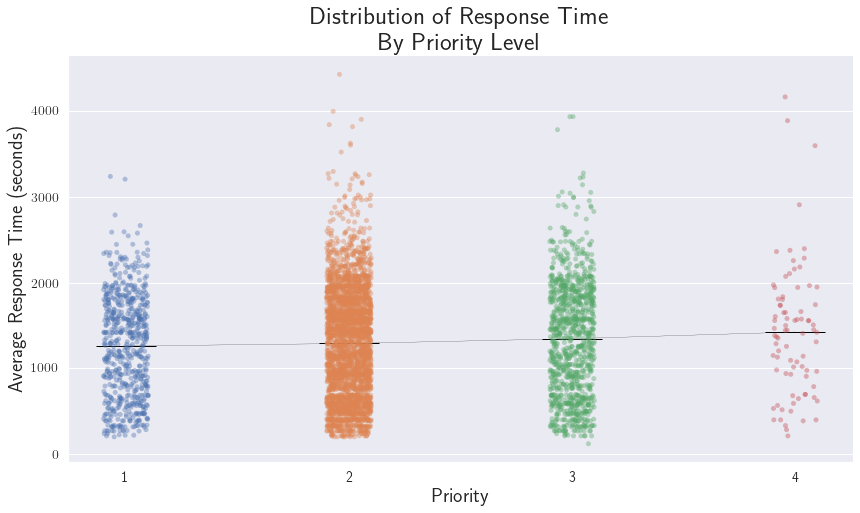

In [ ]:
sns.set_style('darkgrid')

sns.catplot(x="Priority", y="Average response time", data=results1_requests, alpha=.4, height=6.27, aspect=11.7/6.27);

plt.plot(range(0, 4), results1_requests.groupby('Priority').mean()['Average response time'], 
         marker='_', linewidth=.2, color="black", alpha=1, markersize=60)

plt.xlabel('Priority', fontsize=20); plt.ylabel('Average Response Time (seconds)', fontsize=20)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.title('Distribution of Response Time\nBy Priority Level', fontsize=25);

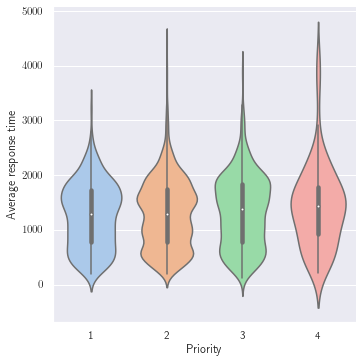

In [ ]:
sns.catplot(x="Priority", y="Average response time", kind="violin", split=True, palette="pastel", data=results1_requests)

<AxesSubplot:xlabel='Priority', ylabel='Average response time'>

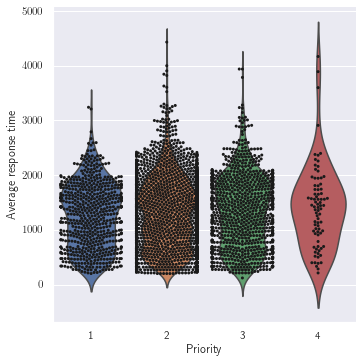

In [ ]:
g = sns.catplot(x="Priority", y="Average response time", kind="violin", inner=None, data=results1_requests)
sns.swarmplot(x="Priority", y="Average response time", color="k", size=1, data=results1_requests, ax=g.ax)

In [ ]:
# Get the number of requests satisfied by each station

sim_example.station_responces().head()

,Name,Count
4184,Brixton (Q2),206
29292,Westminster (F1),200
1905,South Croydon (P2),189
17489,Forest Hill (N6),158
58290,Brent (C3),145


In [ ]:
# Get the number of requests satisfied by each hospital

sim_example.hospital_responces()

,Name,Count
9,The Royal London Hospital,1625
21777,The Princess Grace Hospital,1405
106869,Royal London Hospital for Integrated Medicine,1019
15646,University College Hospital,537
1993,St Thomas' Hospital,199
2011,King Edward VII's Hospital,121
116,London Bridge Hospital,1


In [ ]:
# Save the results

sim_example.region_requests().sort_values(by=['Priority'], ascending=False).reset_index().to_csv('results_requests_priority.csv', index=False)
sim_example.hospital_responces().reset_index().to_csv('results_stations_priority.csv', index=False)

In [ ]:
import seaborn as sns; sns.set()

In [ ]:
results1_requests = sim_example.region_requests() #pd.read_csv('results3_requests.csv')
dict_osm = {x: {'avrg_response': y} for x, y in zip(results1_requests.Node, results1_requests['Average response time'])}

In [ ]:
nx.set_node_attributes(Graph_copy, dict_osm)

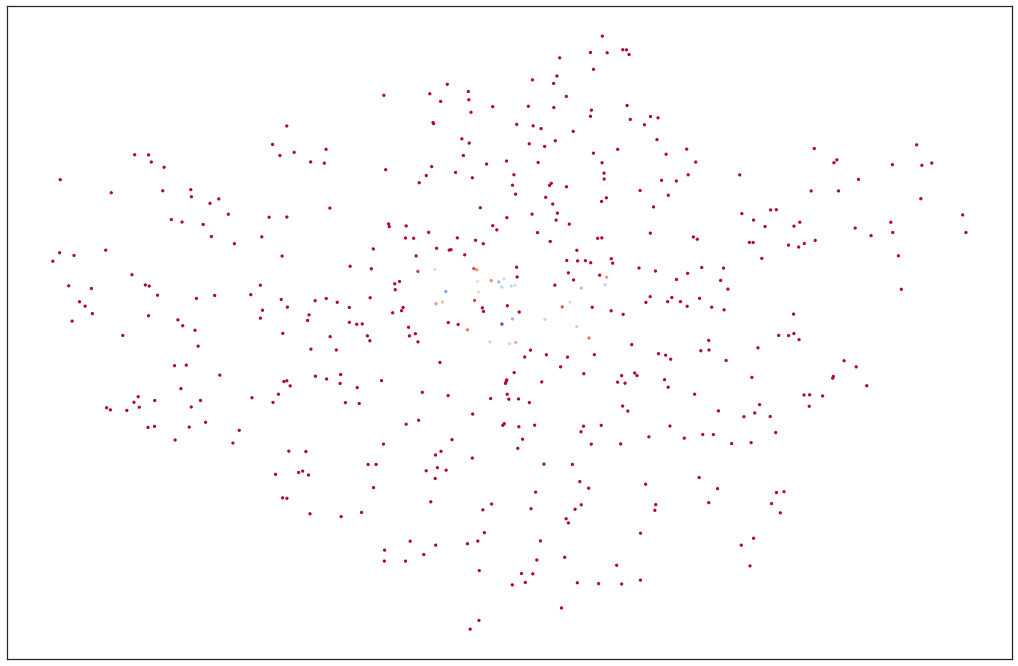

In [ ]:
sns.set_style("white")
plt.figure(figsize=(18, 12))
G = nx.subgraph(Graph_copy, results1_requests.Node)
nx.draw_networkx_nodes(G, pos = dict(zip(G.nodes, [G.nodes[i]['position'] for i in G.nodes])),
                       node_color = list(nx.get_node_attributes(G,'avrg_response').values()), 
                       cmap='coolwarm', node_size=5, vmax=500)
plt.show()

In [ ]:
results1_stations = pd.read_csv('results3_stations.csv')

dict_osm = {x: {'name':y, 'count': z} for x, y, z in zip(results1_stations.iloc[:,0], 
                                                         results1_stations.Name,
                                                         results1_stations.Count)}

In [ ]:
G_stations = nx.subgraph(Graph_copy, results1_stations.iloc[:,0])
nx.set_node_attributes(G_stations, dict_osm)

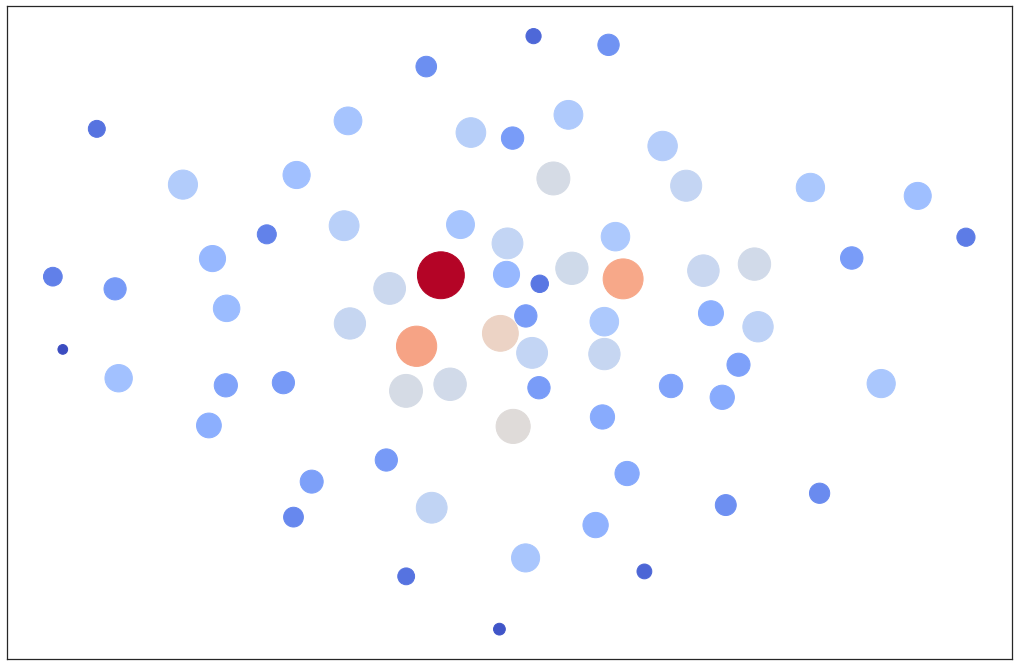

In [ ]:
sns.
plt.figure(figsize=(18, 12))
nx.draw_networkx_nodes(G_stations, node_color = list(nx.get_node_attributes(G_stations,'count').values()),
                       pos = dict(zip(G_stations.nodes, [G_stations.nodes[i]['position'] for i in G_stations.nodes])), 
                       cmap='coolwarm', node_size=np.array(list(nx.get_node_attributes(G_stations,'count').values())))

plt.show()

In [ ]:
#!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng


In [ ]:
from humanfriendly import format_timespan
import seaborn as sns; sns.set()
from matplotlib.ticker import PercentFormatter

history = df['Average response time']
#sim_example.region_requests()['Average response time']

print('Mean of response time: ', format_timespan(np.mean(history)),
      '\n\nConfidence interval:\n', 
      format_timespan(np.percentile(history, 5)), ' | ',
      format_timespan(np.percentile(history, 95)))

plt.figure(figsize=(15, 7))
plt.hist(history, density=1, bins=200, alpha=.7)
#sns.kdeplot(history)
plt.axvline(np.mean(history), color='red', Linewidth=.75)
plt.title('Ambulance Response Time', fontsize=30)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=2))
plt.xlabel('Response time (seconds)', fontsize=20)
plt.show()

In [15]:
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
%matplotlib inline

rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

In [ ]:
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng --fix-missing

In [ ]:
! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

In [38]:
link = 'https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2021/03/AmbSYS-to-Feb-2021.csv'

In [39]:
nhs_data = pd.read_csv(link, squeeze = True)

In [40]:
measurements = ['incidents_count', 'total_seconds', 'rt_mean', '90th']
categories = ['C1', 'C1T', 'C2', 'C3', 'C4']
colnames = []
for cat in categories:
    for m in measurements:
        colnames.append(cat+'_'+m)

calls = ['contact_call', 'calls_answered', 'total_call_answer_time',  
         'mean_call_answer_time', 'median_call_answer_time',    
         '90th_call_answer_time', '95th_call_answer_time', '99th_call_answer_time']

codes = ['A8', 'A24', 'A25', 'A26', 'A9', 'A27', 'A28', 'A29', 'A10', 'A30', 
         'A31', 'A32', 'A11', 'A33', 'A34', 'A35', 'A12', 'A36', 'A37', 'A38',
         'A0', 'A1', 'A2', 'A3', 'A4', 'A114', 'A5', 'A6']

nhs_data = nhs_data.rename(columns=dict(zip(codes, colnames+calls)))

In [41]:
nhs_data = nhs_data[['Year', 'Month', 'Region', 'Org Code', 'Org Name']+colnames+calls]

In [42]:
nhs_london = nhs_data[nhs_data['Org Name']=='LONDON AMBULANCE SERVICE NHS TRUST']
nhs_london = nhs_london.reset_index(drop=True)
nhs_london = nhs_london.replace('.', np.nan)
#nhs_london = nhs_london.dropna()
nhs_london = nhs_london.apply(pd.to_numeric, errors='ignore')
nhs_london.insert(0, 'Time', pd.to_datetime(dict(year=nhs_london.Year, month=nhs_london.Month, day=1)))

In [ ]:

# This graph to check the variance is respone time in areas with different IMD estimates
plt.figure(figsize=(12, 8))
sns.scatterplot(y="imd", x="Average response time", data=merged_data, 
                hue="Average response time", legend='brief', palette='RdYlGn_r', s=20);
#plt.ylabel('Index of Multiple Deprivation', fontsize=20);
#plt.xlabel('Average Response Time (seconds)', fontsize=20);
#plt.title('Index of Multiple Deprivation vs. Response Time\nBoroughs of London', fontsize=25);

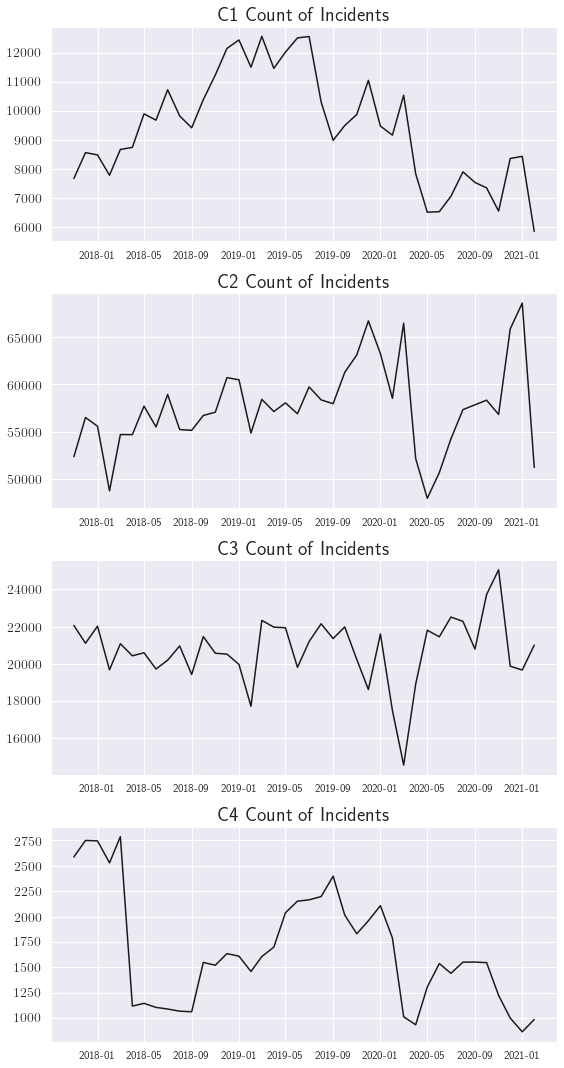

In [60]:
plt.figure(figsize=(8, 15))
for idx, i in enumerate(['C1', 'C2', 'C3', 'C4']):
    plt.subplot(4, 1, idx+1)
    plt.title(i+' Count of Incidents', fontsize=20)
    plt.xticks(fontsize=11); plt.yticks(fontsize=14)
    plt.plot(nhs_london.Time.astype(np.datetime64), nhs_london[i+'_incidents_count'], 'k')
plt.tight_layout();

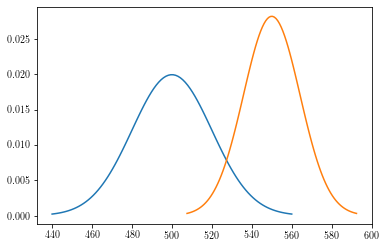

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 500
variance = 400
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))

mu = 550
variance = 200
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))

plt.show()

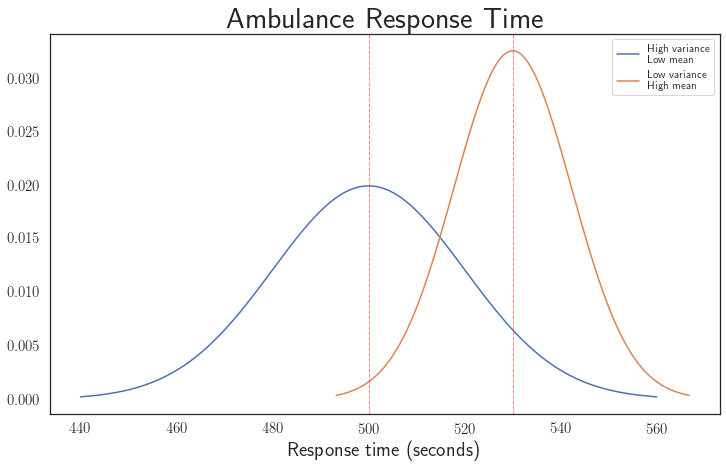

In [39]:
import seaborn as sns
sns.set_style("white")
plt.figure(figsize=(12, 7))

mu = 500
variance = 400
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='High variance\nLow mean')

mu = 530
variance = 150
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='Low variance\nHigh mean')

plt.title('Ambulance Response Time', fontsize=30)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel('Response time (seconds)', fontsize=20)

plt.axvline(500, color='red', Linewidth=.5, ls='-.')
plt.axvline(530, color='red', Linewidth=.5,  ls='-.')
plt.legend()

plt.show()